In [2]:
# Core Libraries
import pandas as pd
import numpy as np
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import sweetviz as sv
from tqdm import tqdm

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA

# Models
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensemble
from sklearn.ensemble import VotingRegressor, StackingRegressor

# Others
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Data Exploration
df = pd.read_csv(r'.\data\historical_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                                19

In [6]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

In [8]:
#dropna if affect < 10% dataset. else impute
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     175777 non-null  float64
 1   created_at                                    175777 non-null  object 
 2   actual_delivery_time                          175777 non-null  object 
 3   store_id                                      175777 non-null  int64  
 4   store_primary_category                        175777 non-null  object 
 5   order_protocol                                175777 non-null  float64
 6   total_items                                   175777 non-null  int64  
 7   subtotal                                      175777 non-null  int64  
 8   num_distinct_items                            175777 non-null  int64  
 9   min_item_price                                175777 

In [15]:
#Create 'delivery_time_minute' target column.
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

df['delivery_time_minutes'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 17 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175777 non-null  float64       
 1   created_at                                    175777 non-null  datetime64[ns]
 2   actual_delivery_time                          175777 non-null  datetime64[ns]
 3   store_id                                      175777 non-null  int64         
 4   store_primary_category                        175777 non-null  object        
 5   order_protocol                                175777 non-null  float64       
 6   total_items                                   175777 non-null  int64         
 7   subtotal                                      175777 non-null  int64         
 8   num_distinct_items                            175777 non-nu

In [21]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
market_id,175777.0,2.743726,1.0,2.0,2.0,4.0,6.0,1.330963
created_at,175777,2015-02-04 19:57:50.009631744,2015-01-21 15:22:03,2015-01-29 01:31:19,2015-02-05 02:41:26,2015-02-12 01:04:32,2015-02-18 06:00:44,NaN
actual_delivery_time,175777,2015-02-04 20:45:36.432303616,2015-01-21 16:16:34,2015-01-29 02:18:30,2015-02-05 03:45:31,2015-02-12 01:47:32,2015-02-19 22:45:31,NaN
store_id,175777.0,3556.299561,1.0,1703.0,3620.0,5341.0,6987.0,2055.959006
order_protocol,175777.0,2.911752,1.0,1.0,3.0,4.0,7.0,1.513128
total_items,175777.0,3.204976,1.0,2.0,3.0,4.0,411.0,2.674055
subtotal,175777.0,2697.111147,0.0,1412.0,2224.0,3410.0,26800.0,1828.554893
num_distinct_items,175777.0,2.67506,1.0,1.0,2.0,3.0,20.0,1.625681
min_item_price,175777.0,684.965433,-86.0,299.0,595.0,942.0,14700.0,519.882924
max_item_price,175777.0,1160.158616,0.0,799.0,1095.0,1395.0,14700.0,560.828571


                                             |          | [  0%]   00:00 -> (? left)


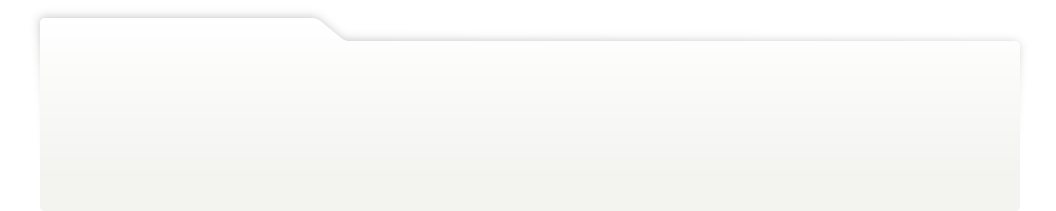
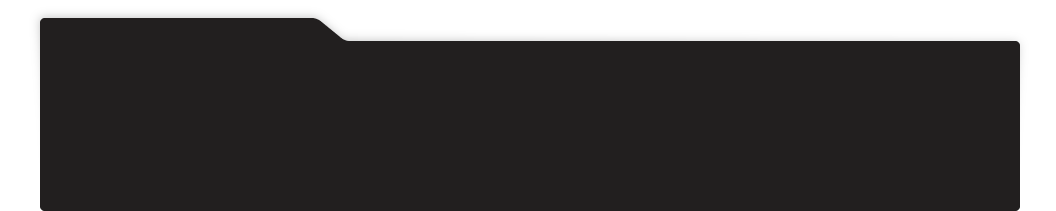
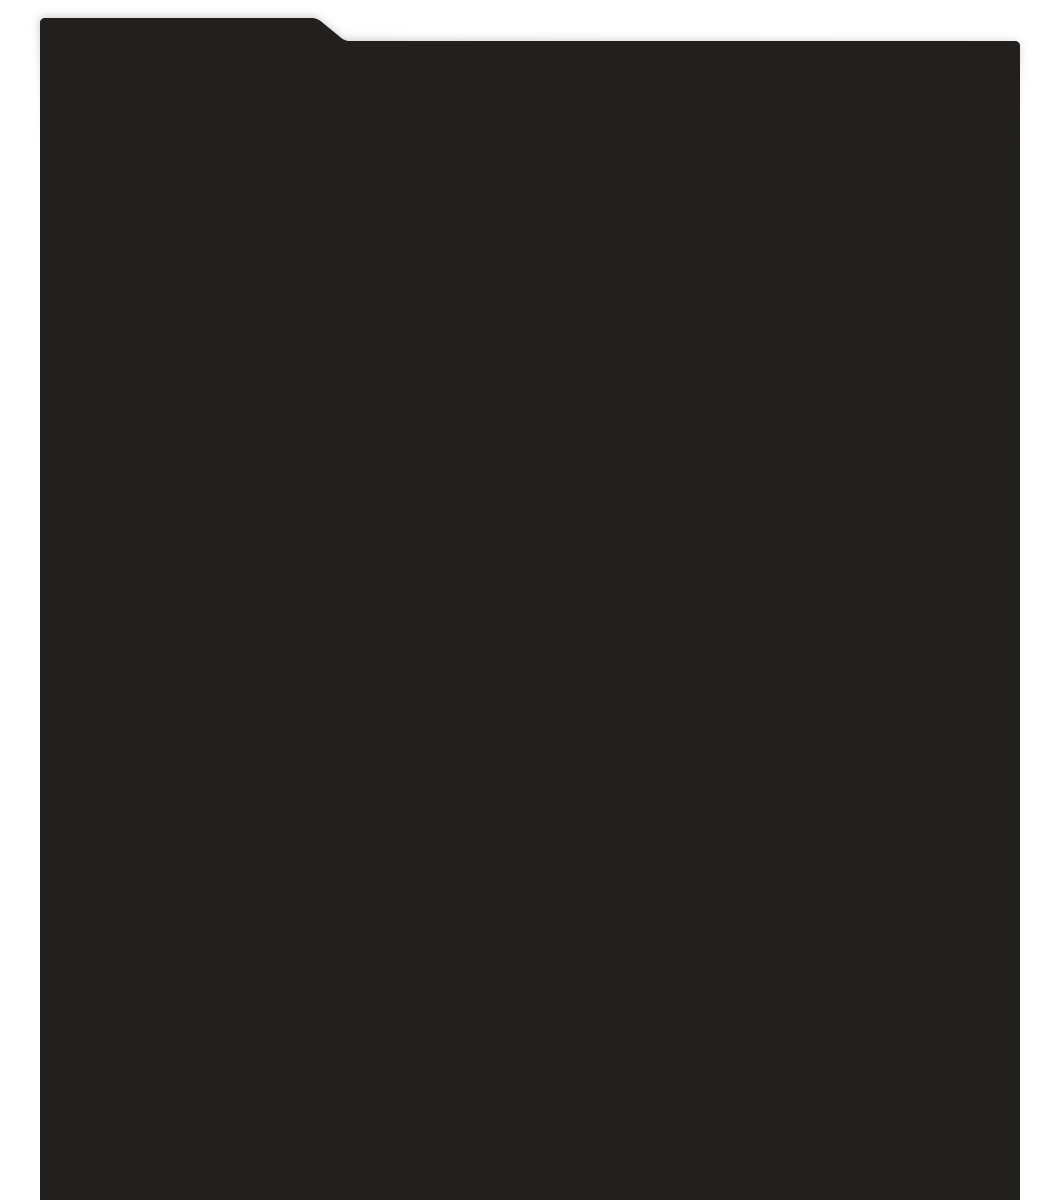
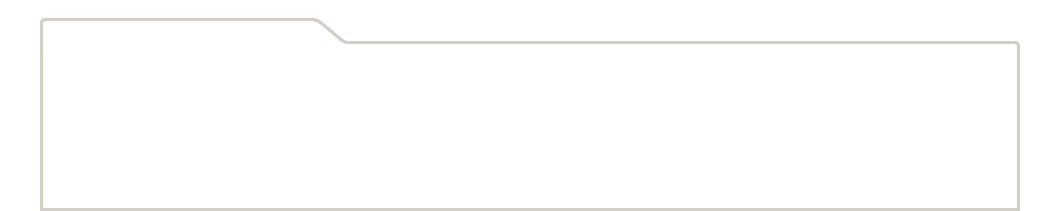
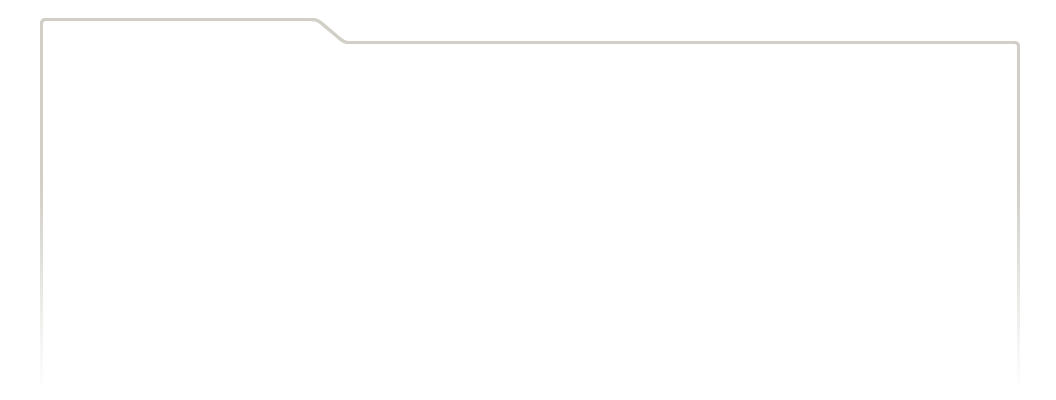
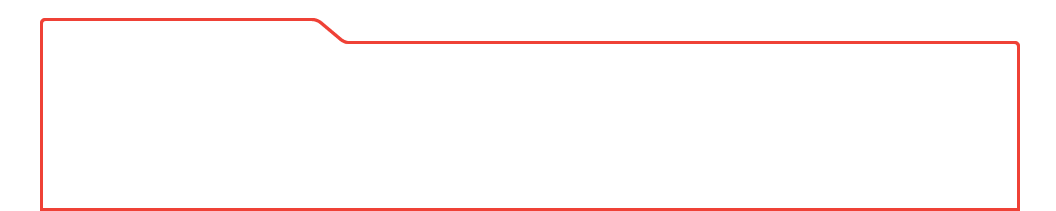
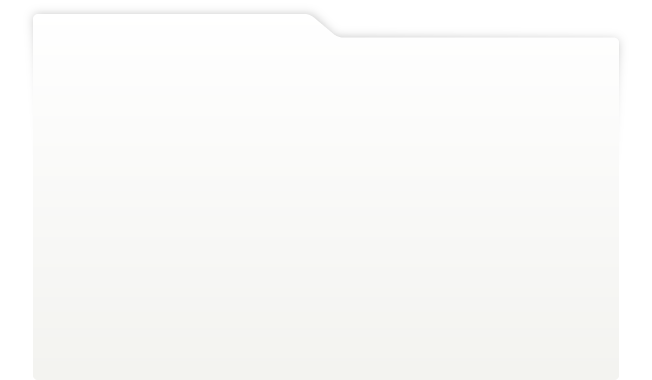
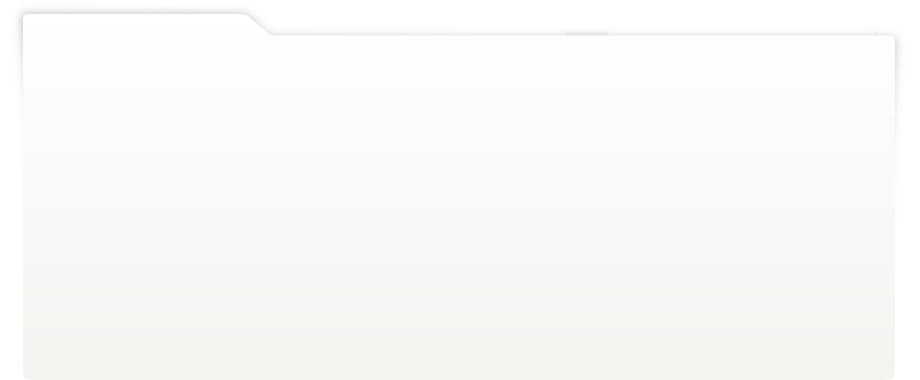
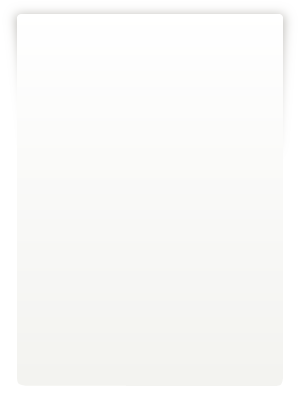
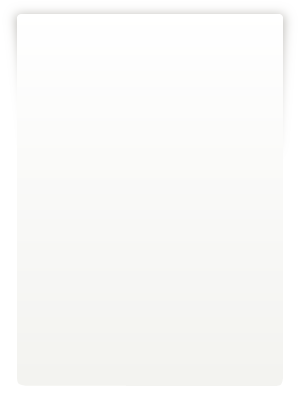
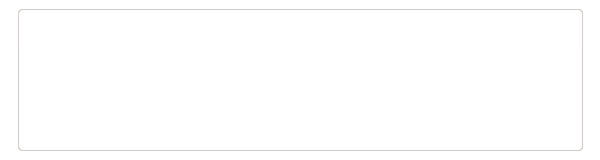
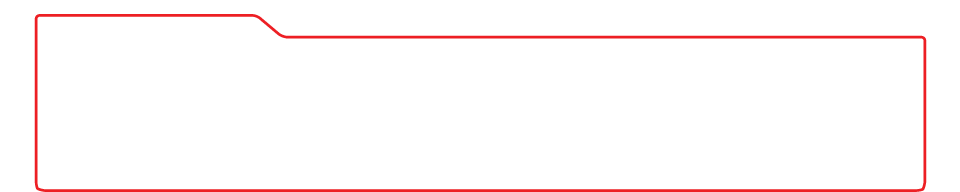
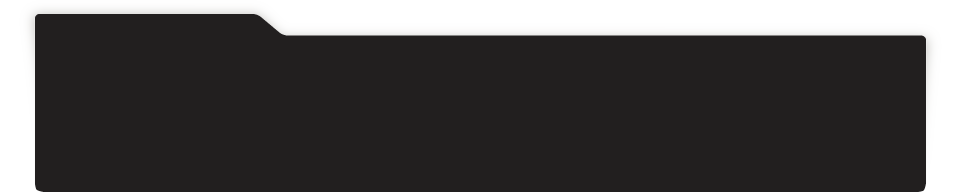
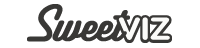
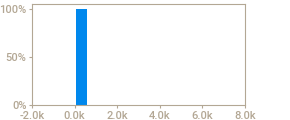
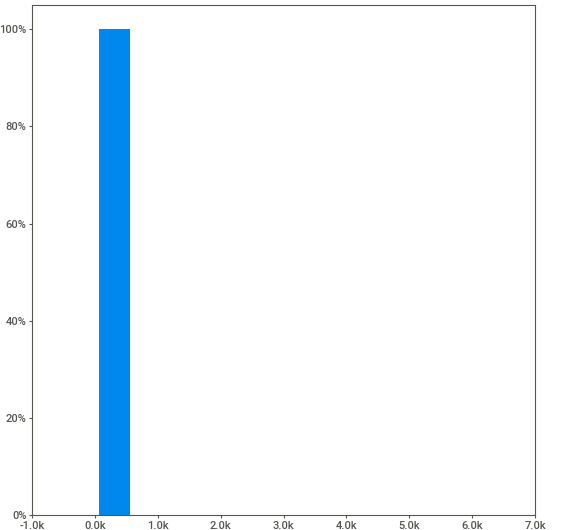
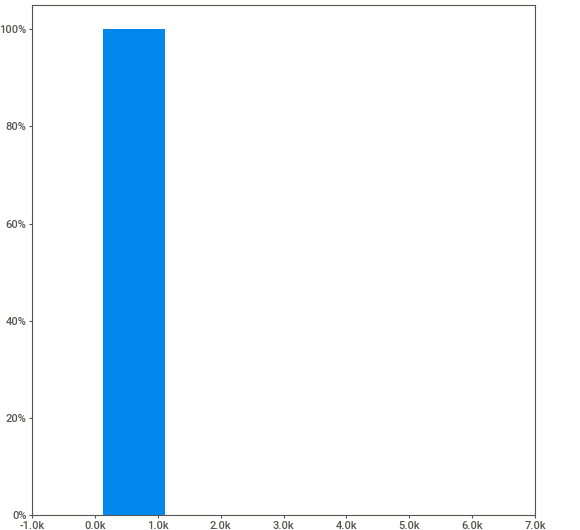
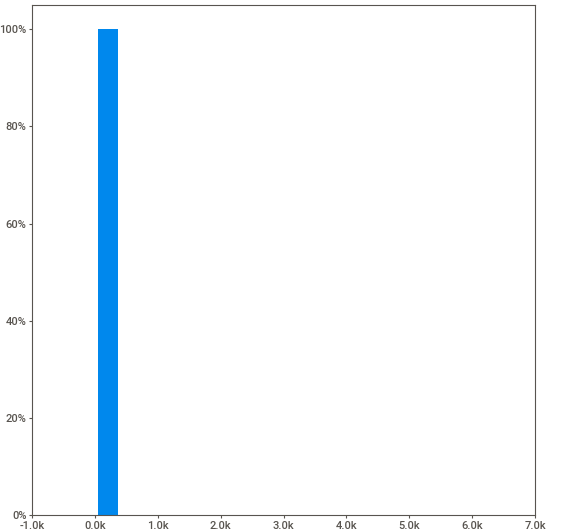
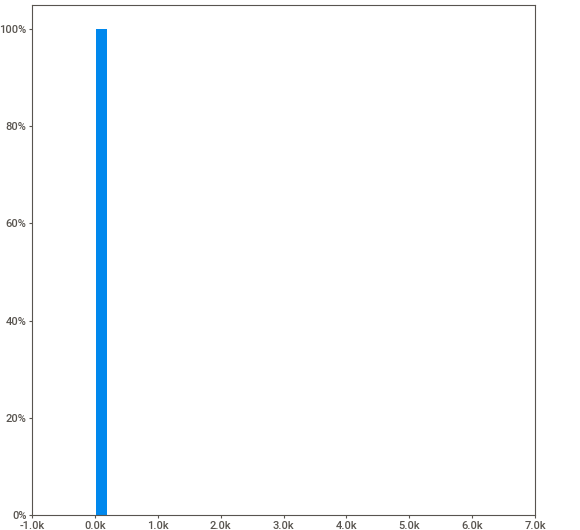
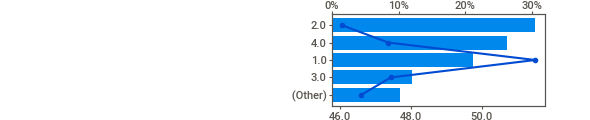
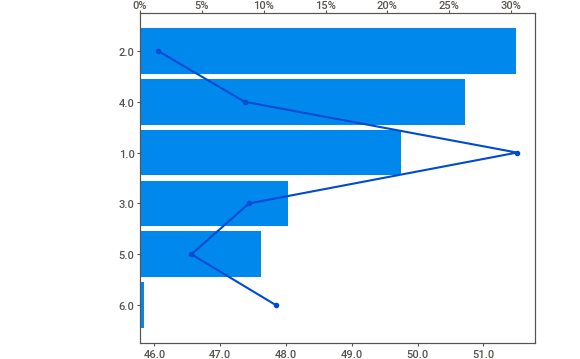
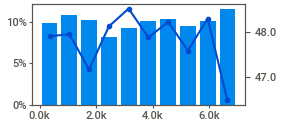
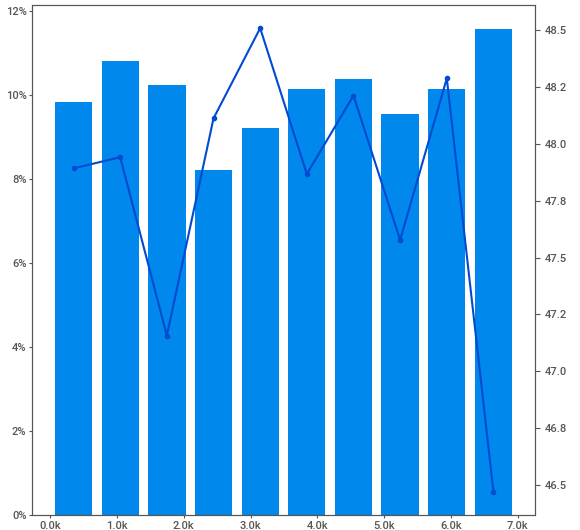
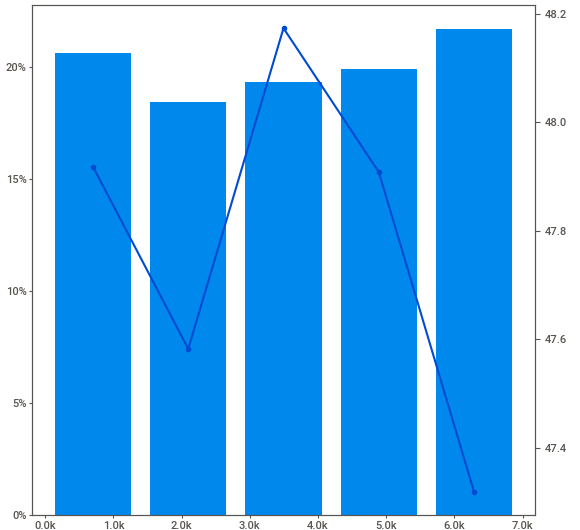
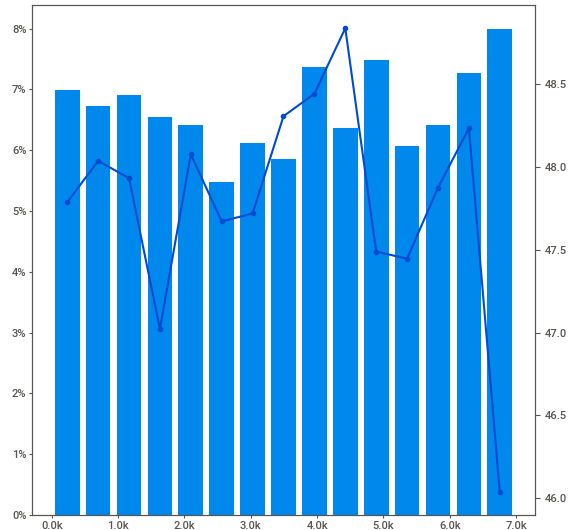
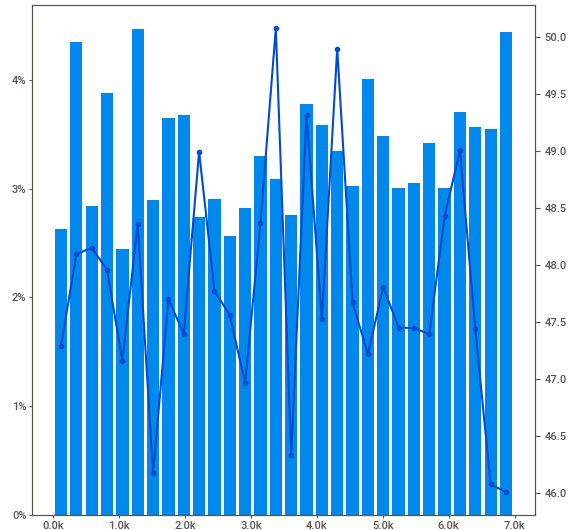
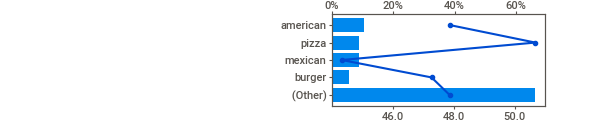
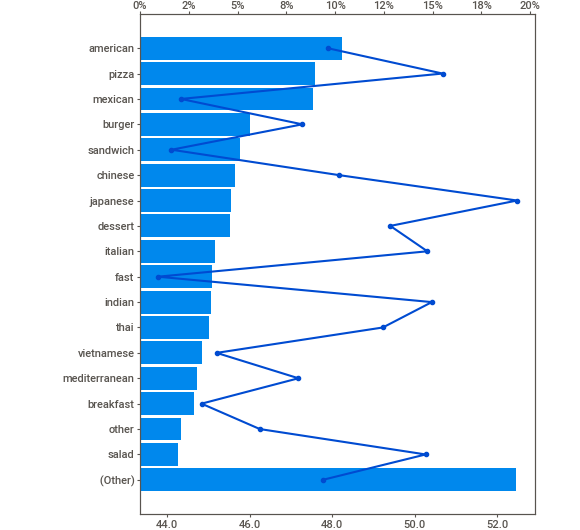
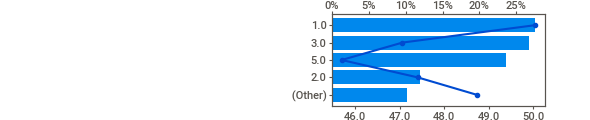
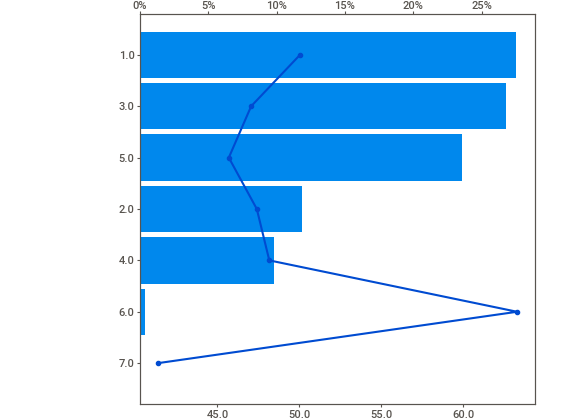
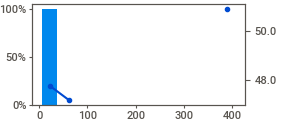
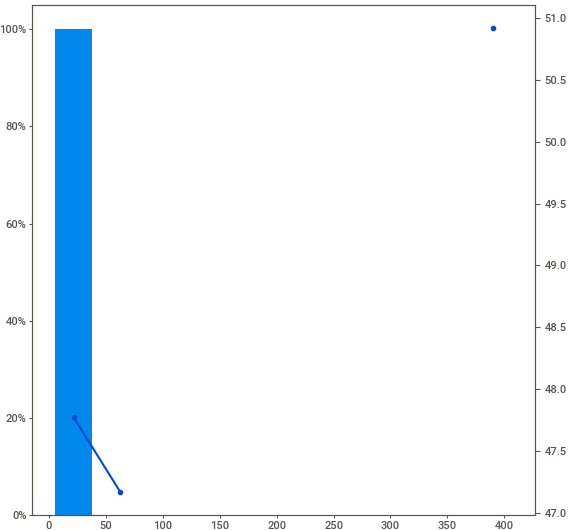
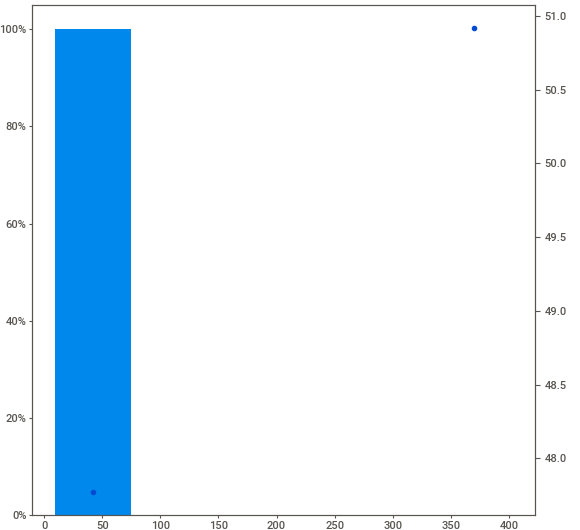
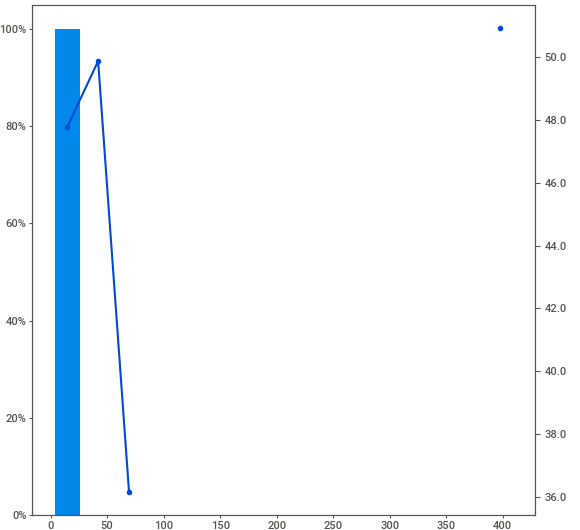
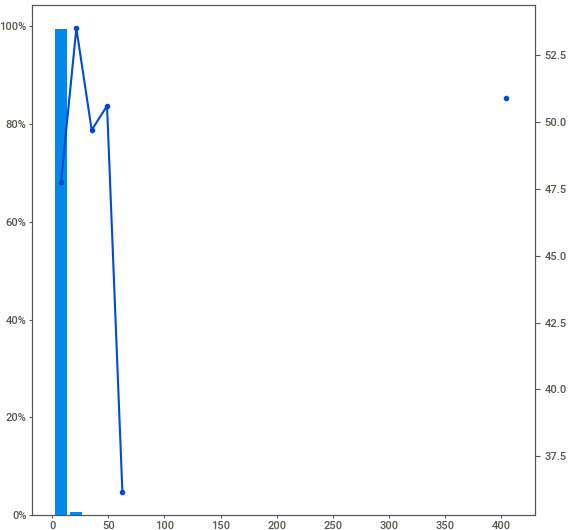
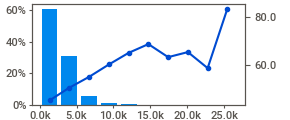
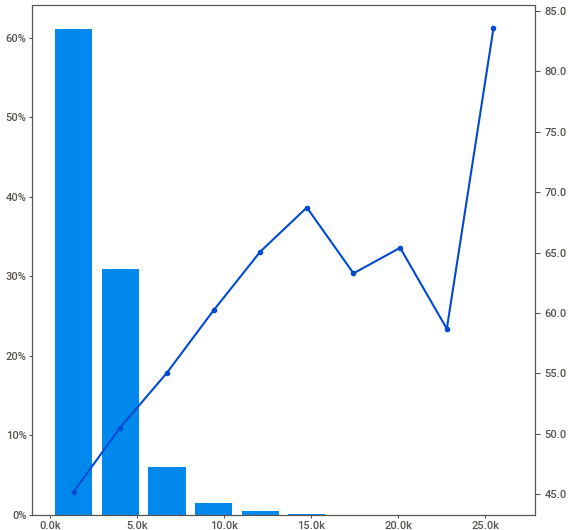
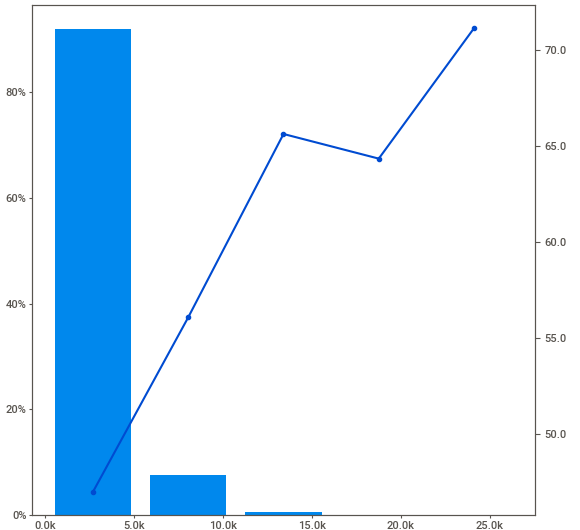
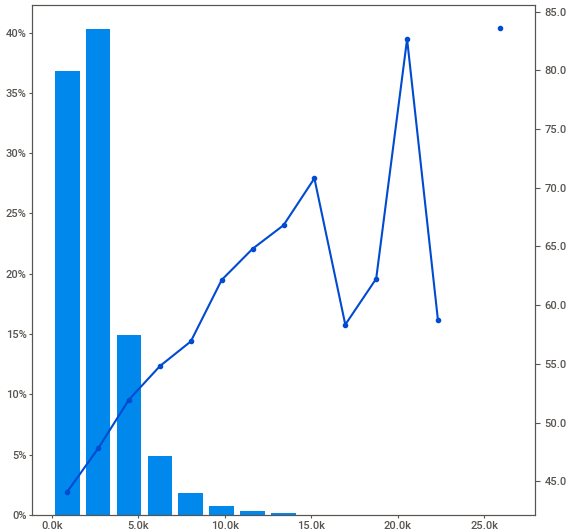
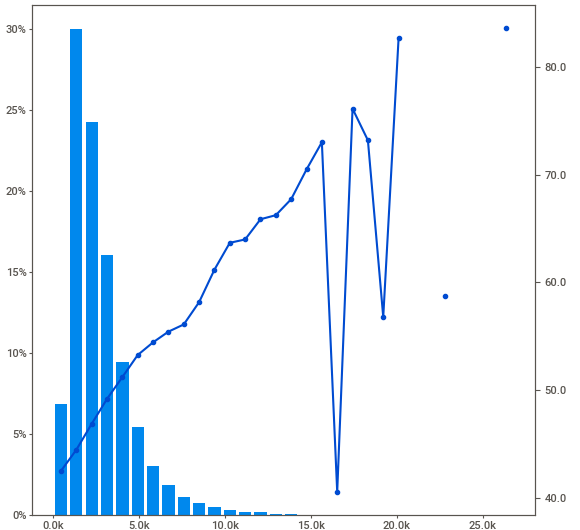
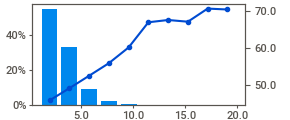
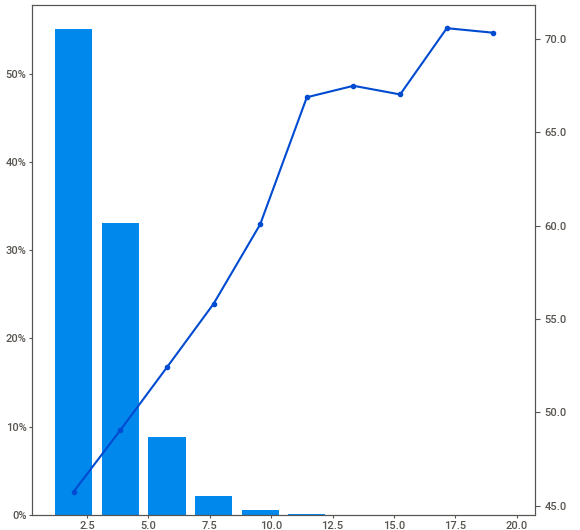
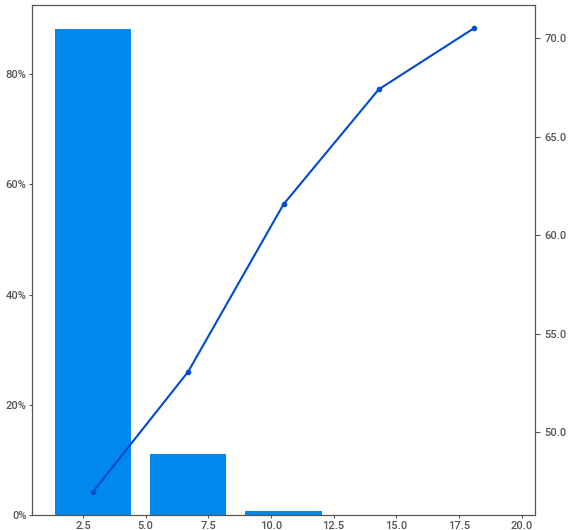
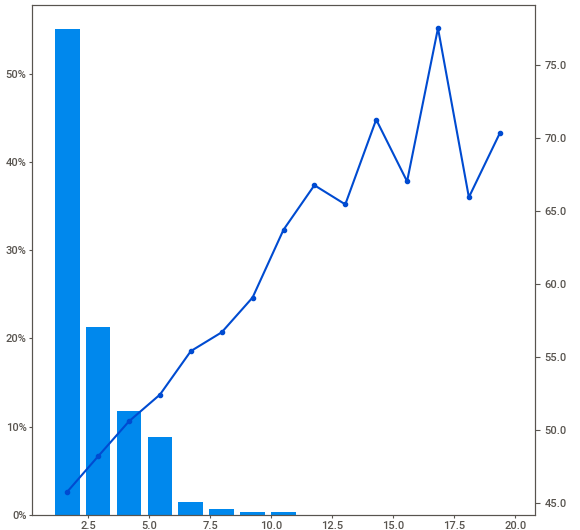
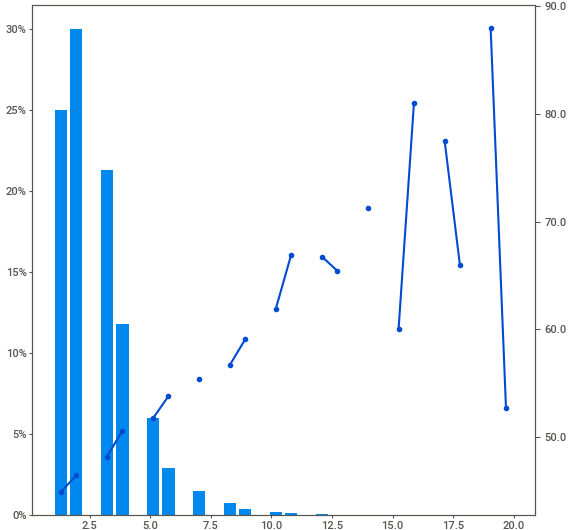
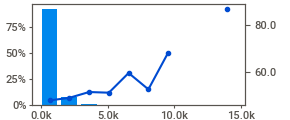
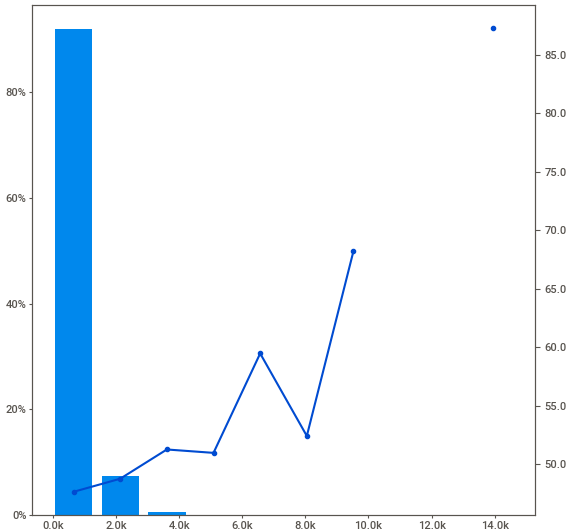
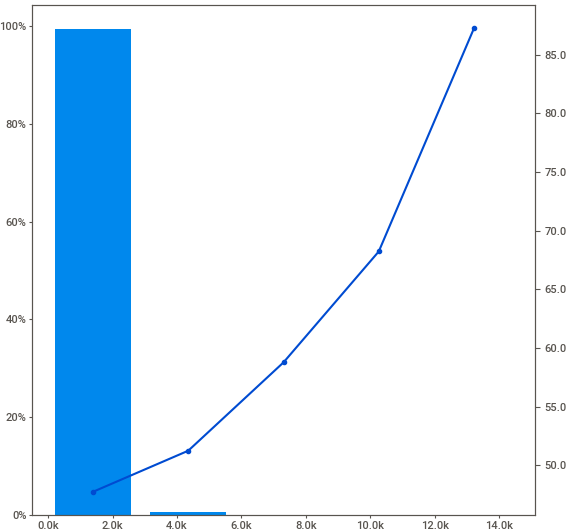
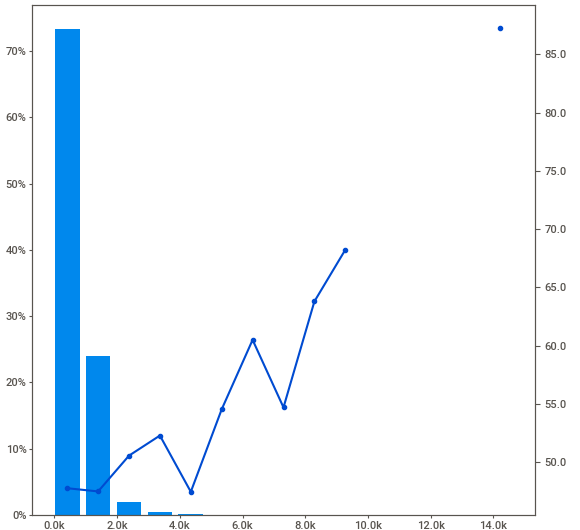
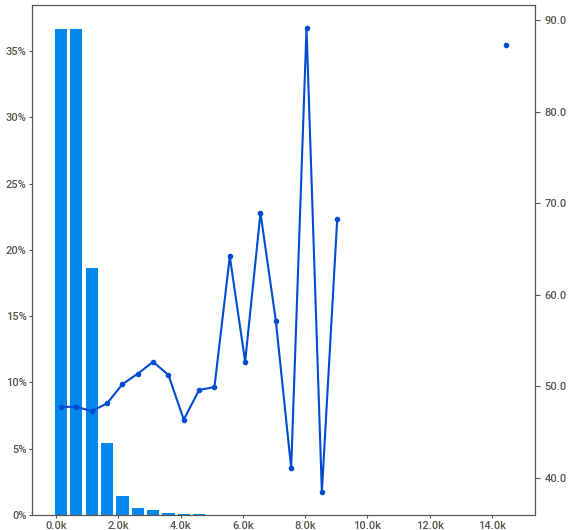
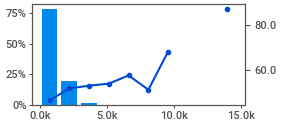
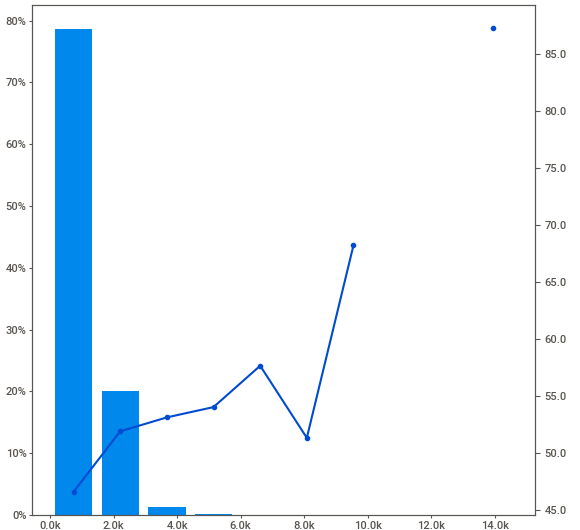
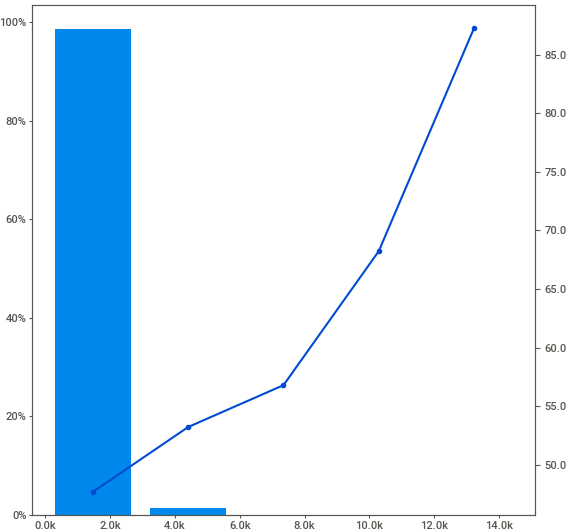
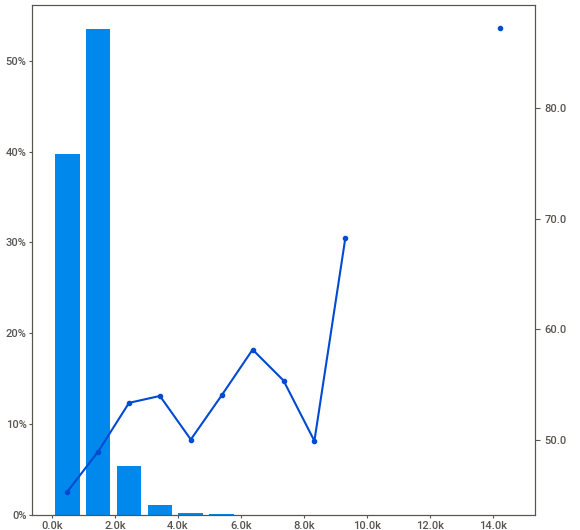
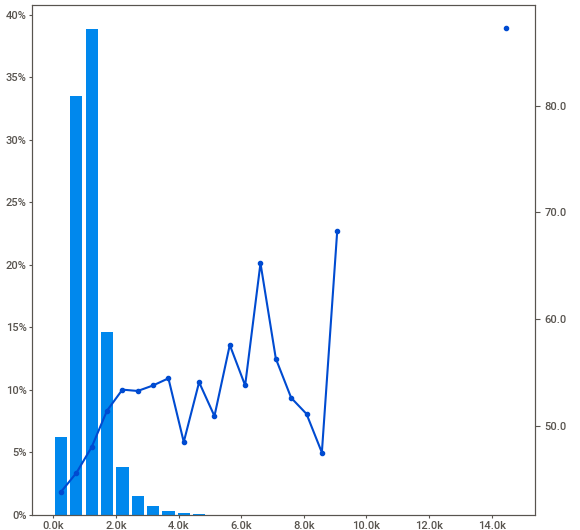
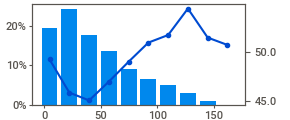
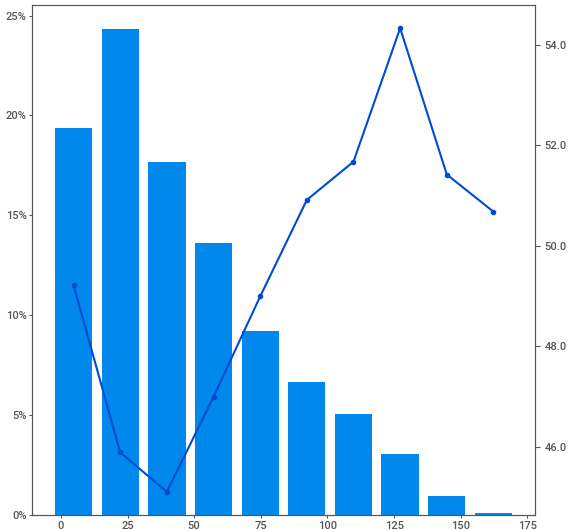
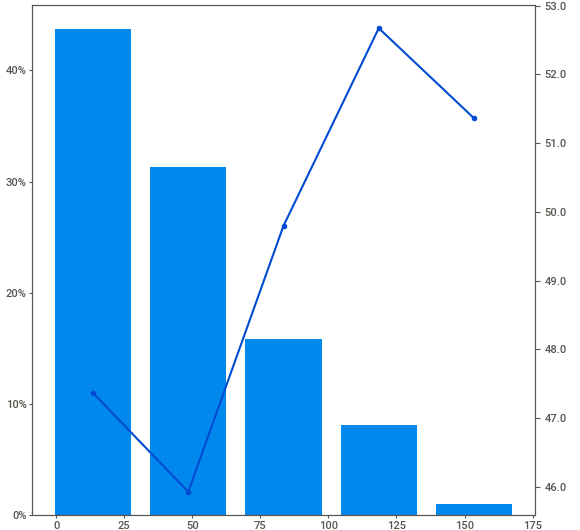
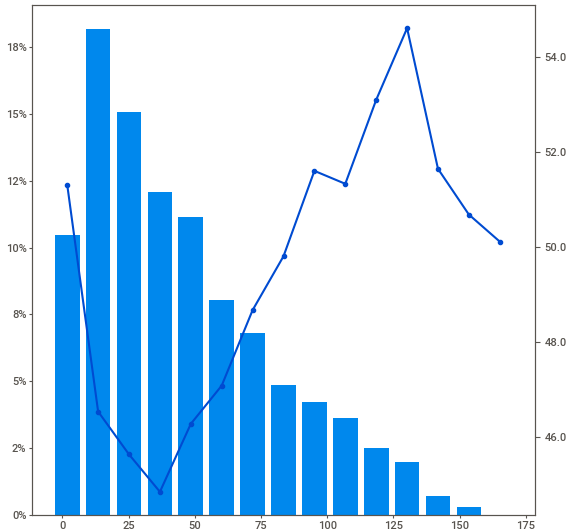
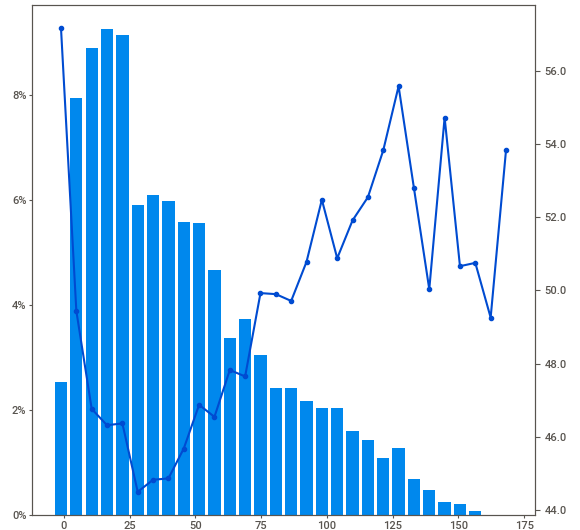
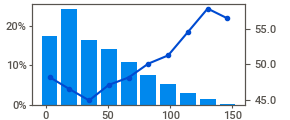
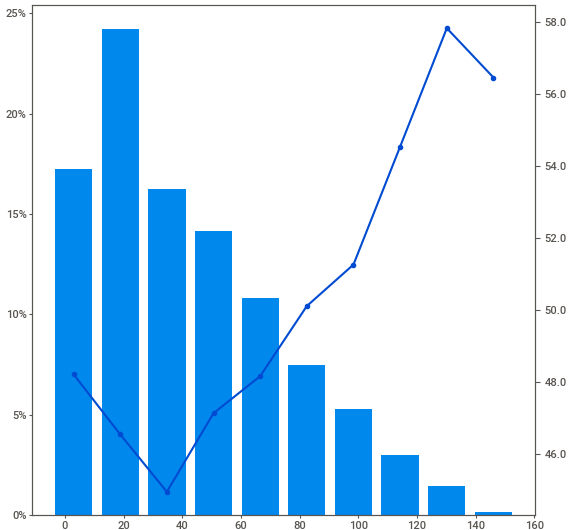
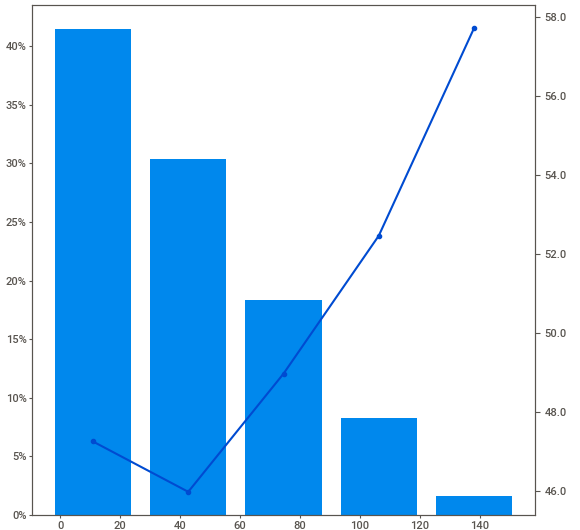
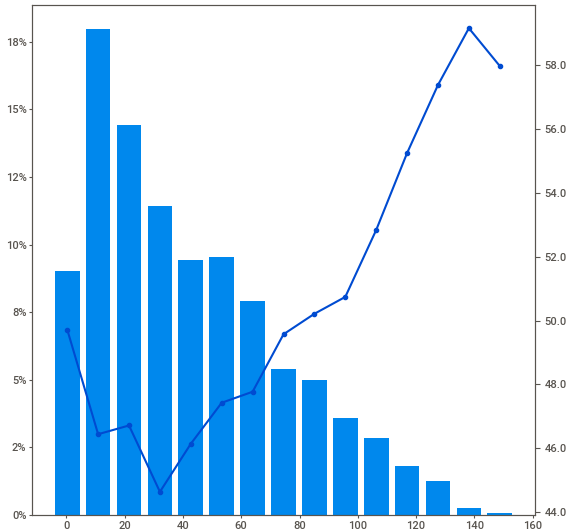
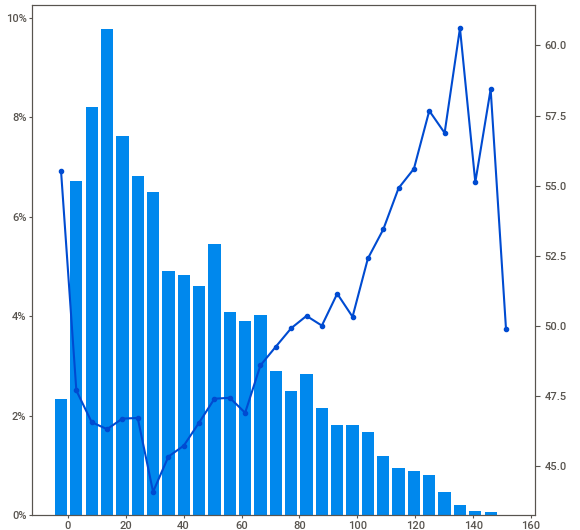
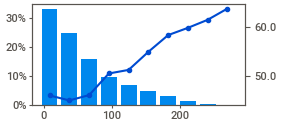
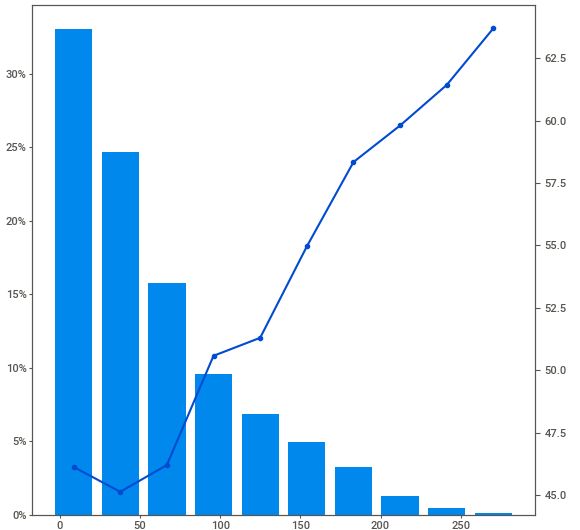
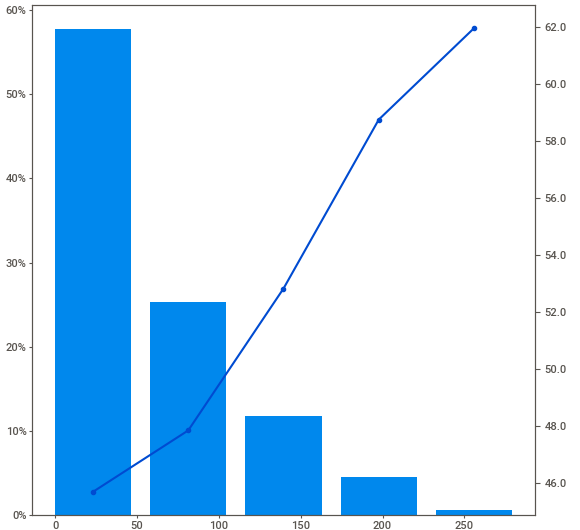
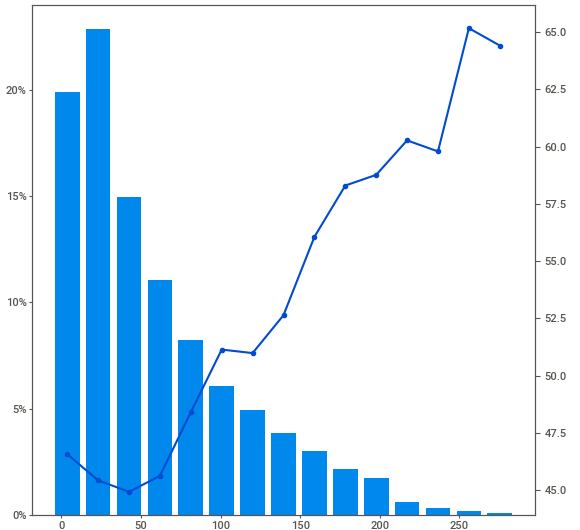
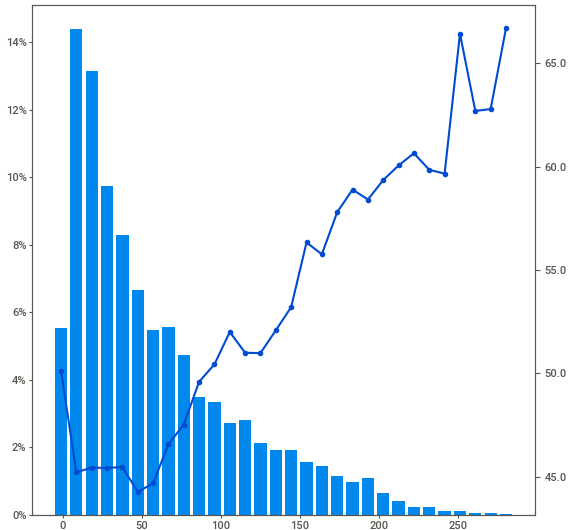
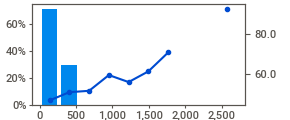
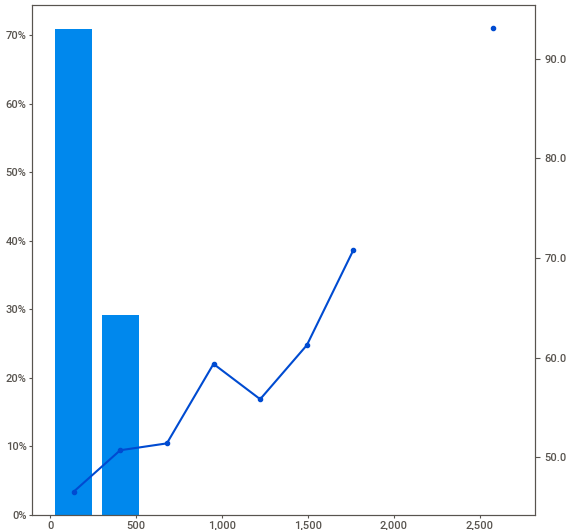
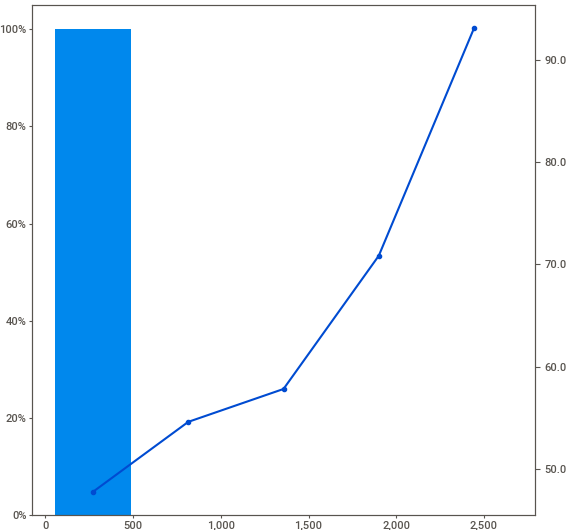
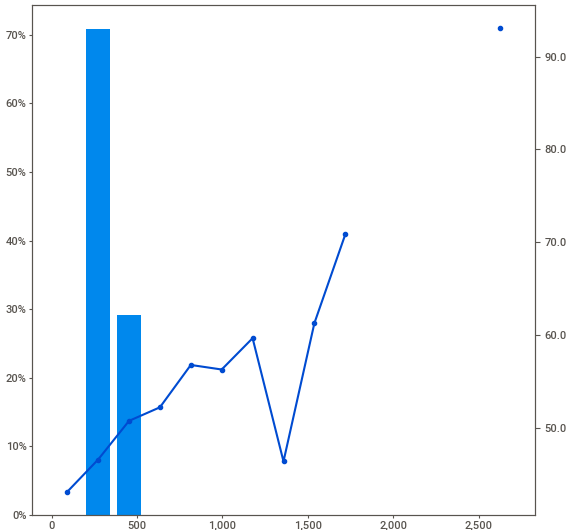
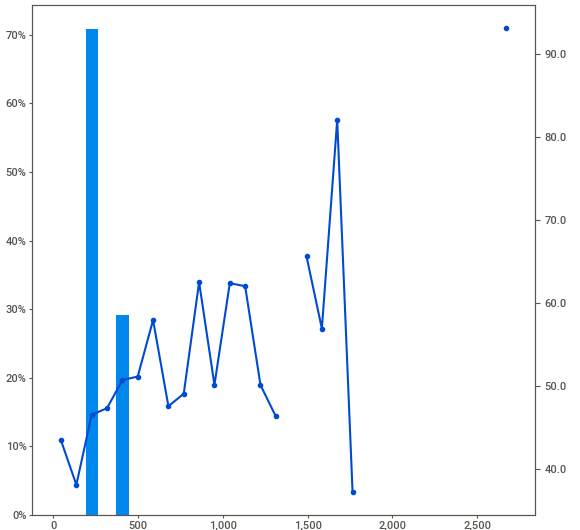
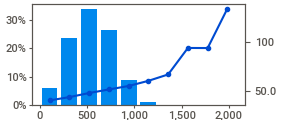
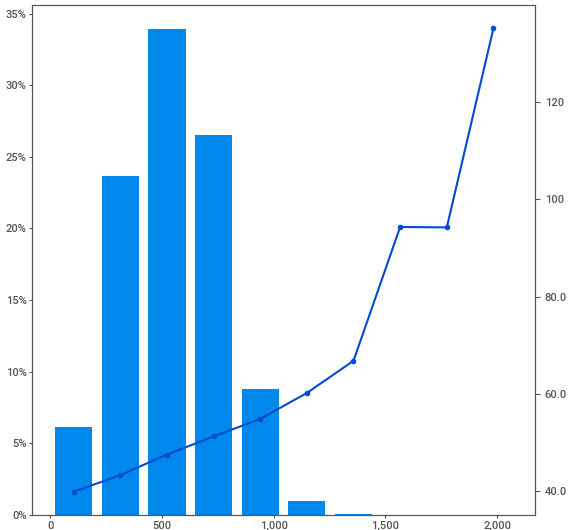
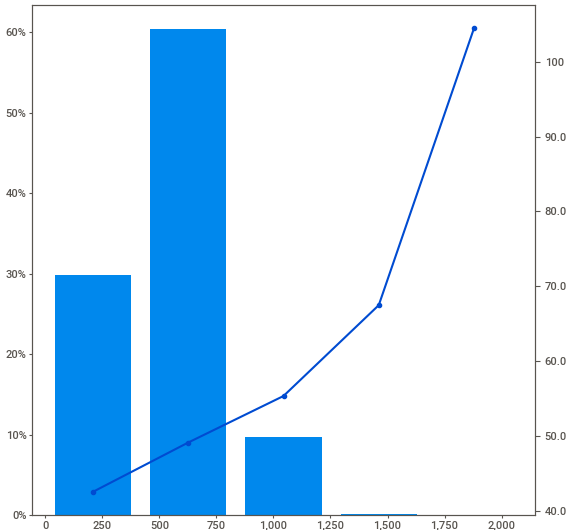
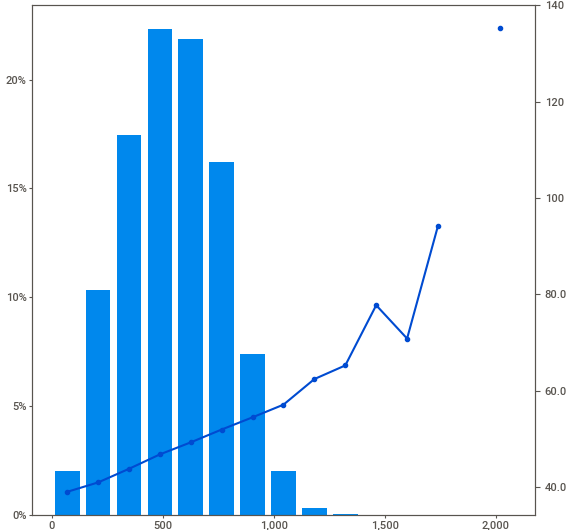
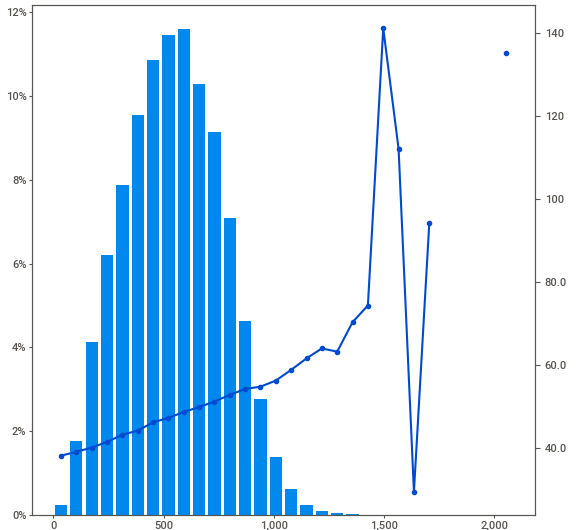
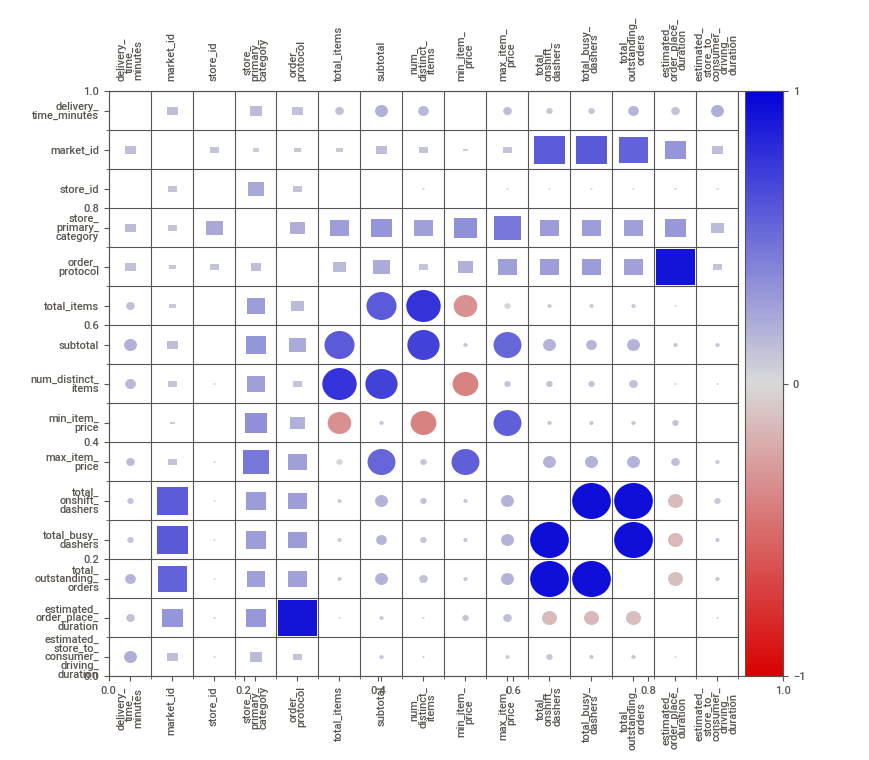
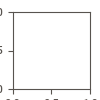

In [23]:
#Feature engineering
my_report = sv.analyze(df,'delivery_time_minutes')
my_report.show_notebook(w="100%", h="full")

In [25]:
#Create 'delay_time' column
df['dasher_latecy_rate'] = df['total_busy_dashers'] / df['total_onshift_dashers']
df['delay_time'] = df['estimated_store_to_consumer_driving_duration'] + df['estimated_order_place_duration']

In [27]:
#Split created_at into day & week
def split_date(df):
    df['Day'] = df.created_at.dt.day
    df['WeekOfYear'] = df.created_at.dt.isocalendar().week
split_date(df)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 21 columns):
 #   Column                                        Non-Null Count   Dtype         
---  ------                                        --------------   -----         
 0   market_id                                     175777 non-null  float64       
 1   created_at                                    175777 non-null  datetime64[ns]
 2   actual_delivery_time                          175777 non-null  datetime64[ns]
 3   store_id                                      175777 non-null  int64         
 4   store_primary_category                        175777 non-null  object        
 5   order_protocol                                175777 non-null  float64       
 6   total_items                                   175777 non-null  int64         
 7   subtotal                                      175777 non-null  int64         
 8   num_distinct_items                            175777 non-nu

In [31]:
#Drop unnecessary column
drop_colums = [
    'market_id',
    'created_at',
    'actual_delivery_time',
    'store_id',
    'total_busy_dashers',
    'total_onshift_dashers',
    'estimated_store_to_consumer_driving_duration',
    'estimated_order_place_duration'
]
df.drop(inplace=True, axis=1, columns=drop_colums)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175777 entries, 0 to 197427
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   store_primary_category    175777 non-null  object 
 1   order_protocol            175777 non-null  float64
 2   total_items               175777 non-null  int64  
 3   subtotal                  175777 non-null  int64  
 4   num_distinct_items        175777 non-null  int64  
 5   min_item_price            175777 non-null  int64  
 6   max_item_price            175777 non-null  int64  
 7   total_outstanding_orders  175777 non-null  float64
 8   delivery_time_minutes     175777 non-null  float64
 9   dasher_latecy_rate        172274 non-null  float64
 10  delay_time                175777 non-null  float64
 11  Day                       175777 non-null  int32  
 12  WeekOfYear                175777 non-null  UInt32 
dtypes: UInt32(1), float64(5), int32(1), int64(5), obj

In [35]:
#Remove outliers
def remove_outliers_iqr(df):
    df_cleaned = df.copy()
    
    for column in df_cleaned.select_dtypes(include=['float64', 'int64', 'int32', 'UInt32']).columns:
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    return df_cleaned

df_cleaned = remove_outliers_iqr(df)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 123856 entries, 8 to 197427
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   store_primary_category    123856 non-null  object 
 1   order_protocol            123856 non-null  float64
 2   total_items               123856 non-null  int64  
 3   subtotal                  123856 non-null  int64  
 4   num_distinct_items        123856 non-null  int64  
 5   min_item_price            123856 non-null  int64  
 6   max_item_price            123856 non-null  int64  
 7   total_outstanding_orders  123856 non-null  float64
 8   delivery_time_minutes     123856 non-null  float64
 9   dasher_latecy_rate        123856 non-null  float64
 10  delay_time                123856 non-null  float64
 11  Day                       123856 non-null  int32  
 12  WeekOfYear                123856 non-null  UInt32 
dtypes: UInt32(1), float64(5), int32(1), int64(5), obj

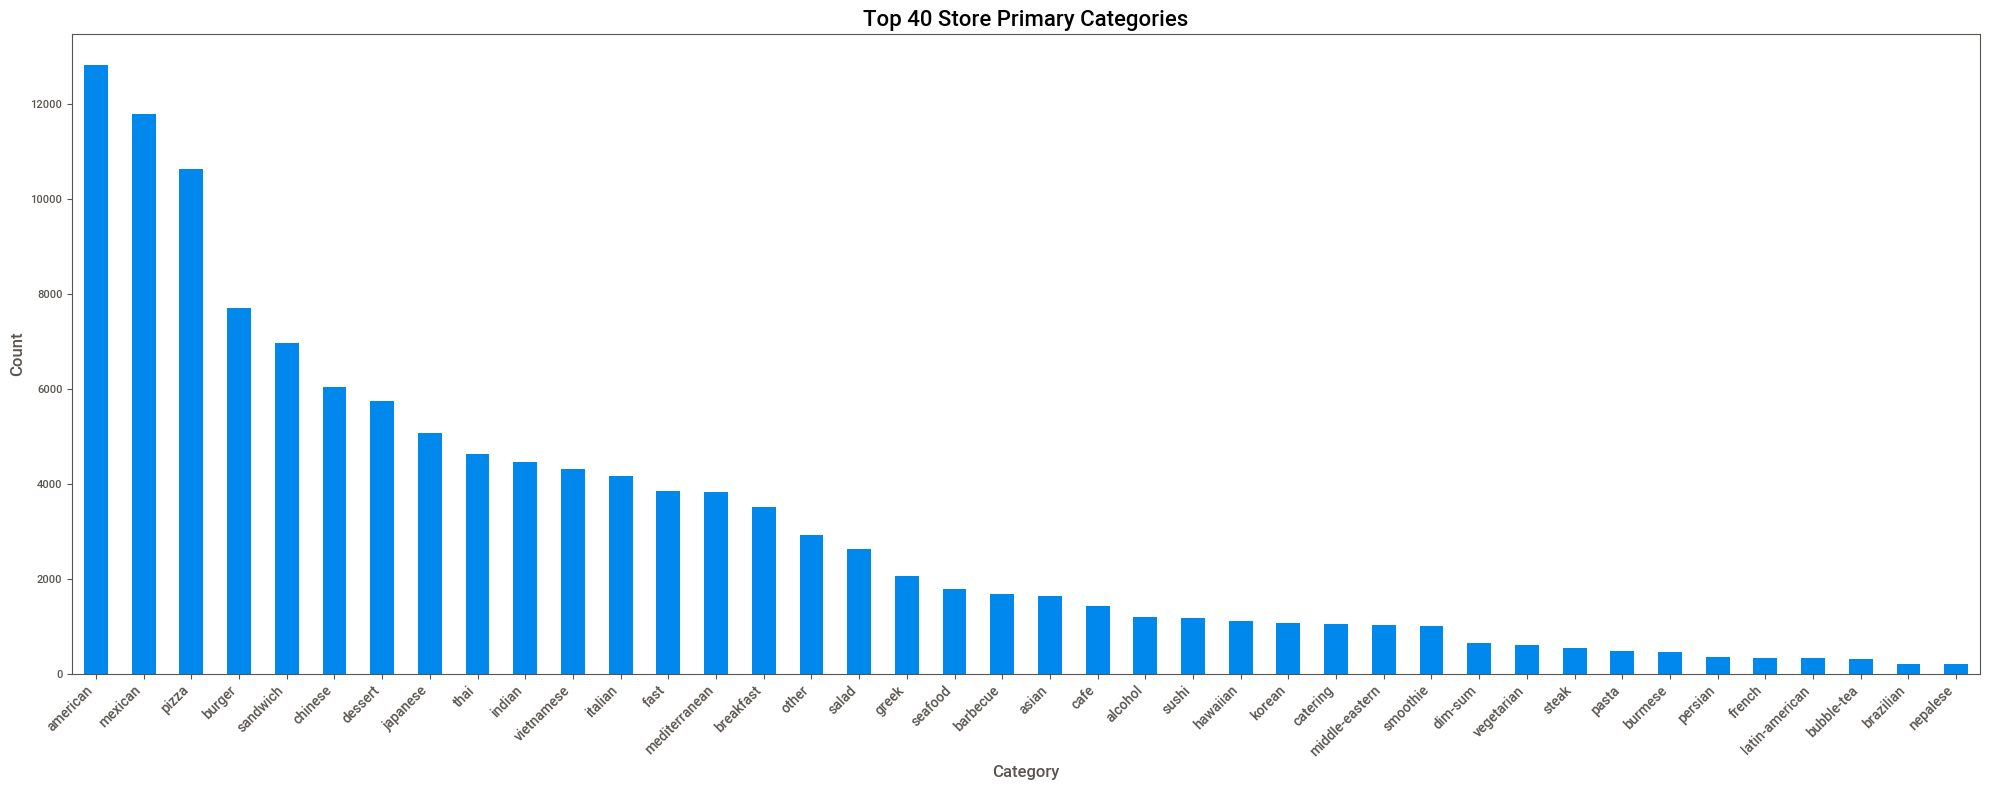

In [37]:
#Visual of the only object(store_primary_category)
plt.figure(figsize=(20, 8))
df_cleaned['store_primary_category'].value_counts().head(40).plot(kind='bar')
plt.title('Top 40 Store Primary Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

In [39]:
# Always parquet after cleaning data/feature engineering

# df_cleaned.to_parquet('df_cleaned')
# df_cleaned = pd.read_parquet(df_cleaned)

In [41]:
#Train,Validation and Test
train_val_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.20, random_state=42)

print('train_df.shape: ',train_df.shape)
print('val_df.shape: ',val_df.shape)
print('test_df.shape: ',test_df.shape)

train_df.shape:  (79267, 13)
val_df.shape:  (19817, 13)
test_df.shape:  (24772, 13)


In [43]:
# X=input, y=target
X_cols = list(df_cleaned.drop(['delivery_time_minutes'], axis=1))
y_col = 'delivery_time_minutes'

train_inputs, train_target = train_df[X_cols].copy(), train_df[y_col].copy()
val_inputs, val_target = val_df[X_cols].copy(), val_df[y_col].copy()
test_inputs, test_target = test_df[X_cols].copy(), test_df[y_col].copy()

In [45]:
#Features for impute,scale & encode
categorical_features = ['store_primary_category']
numerical_features = [
    'order_protocol', 'total_items', 'subtotal', 'num_distinct_items',
    'min_item_price', 'max_item_price', 'total_outstanding_orders', 'dasher_latecy_rate', 'delay_time', 'Day', 'WeekOfYear'
]

In [49]:
#Preprocessor for pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)) 
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

#Models to train with default hyperparameter
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'GradientBoosting': GradientBoostingRegressor(),
    'AdaBoost': AdaBoostRegressor(estimator=DecisionTreeRegressor()),
    'XGBoost': XGBRegressor(),
    'CatBoost': CatBoostRegressor(verbose=0)
}

#Creating pipeline
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

In [51]:
results = {}
for name, model in tqdm(models.items(), desc="Evaluating Models"):
    pipeline = create_pipeline(model)
    pipeline.fit(train_inputs, train_target)
    y_pred = pipeline.predict(val_inputs)
    
    mse = mean_squared_error(val_target, y_pred, squared=False)
    mae = mean_absolute_error(val_target, y_pred)
    r2 = r2_score(val_target, y_pred)
    
    results[name] = {'MSE': mse, 'MAE': mae, 'R^2': r2}

for model_name, metrics in results.items():
    print(f"{model_name}: MSE={metrics['MSE']:.2f}, MAE={metrics['MAE']:.2f}, R^2={metrics['R^2']:.2f}")

Evaluating Models: 100%|██████████| 6/6 [01:36<00:00, 16.08s/it]

Ridge: MSE=12.76, MAE=10.18, R^2=0.17
Lasso: MSE=13.02, MAE=10.43, R^2=0.14
GradientBoosting: MSE=12.61, MAE=10.06, R^2=0.19
AdaBoost: MSE=12.93, MAE=10.16, R^2=0.15
XGBoost: MSE=12.54, MAE=9.98, R^2=0.20
CatBoost: MSE=12.37, MAE=9.85, R^2=0.22


In [53]:
# Top 3 model CarBoost(1), XGBoost(2), GradientBoosting(3)
# CatBoost: MSE=12.37, MAE=9.85, R^2=0.22
# XGBoost: MSE=12.54, MAE=9.98, R^2=0.20
# GradientBoosting: MSE=12.61, MAE=10.06, R^2=0.19

# Worst model Lasso
# Lasso: MSE=13.02, MAE=10.43, R^2=0.14

In [55]:
#Helper Function to Tune Hyperparameter
import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
    """Trains a model with the given parameters and returns training & validation RMSE"""
    pipeline = create_pipeline(ModelClass(**params))
    model = pipeline.fit(train_inputs, train_target)
    train_rmse = mean_squared_error(model.predict(train_inputs), train_target, squared=False)
    val_rmse = mean_squared_error(model.predict(val_inputs), val_target, squared=False)
    return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
    """Trains multiple models by varying the value of param_name according to param_values"""
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelClass, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
    
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])
    plt.show()

#basic hyperparameter
basic_params = {
    'random_state': 42,
    'max_depth': 10,
    'learning_rate': 0.9,
    'subsample': 0.8
}

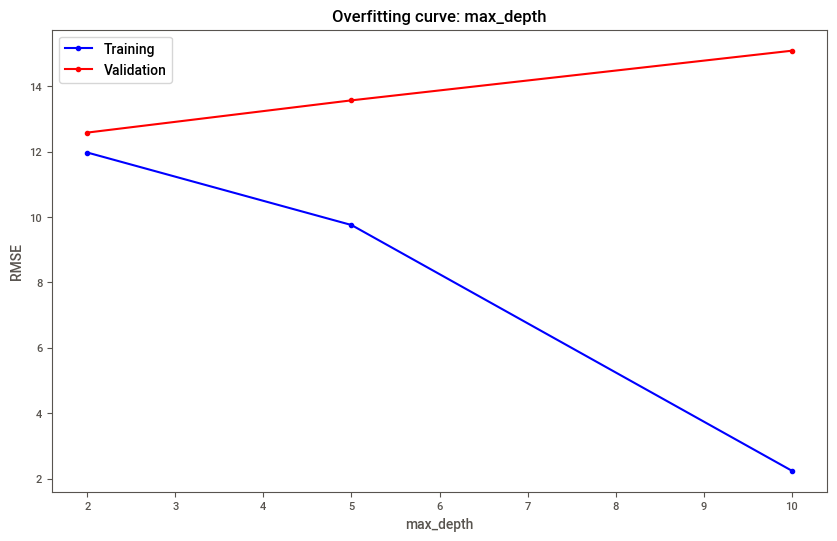

In [57]:
test_param_and_plot(CatBoostRegressor, 'max_depth', [2, 5, 10], verbose=0, **basic_params)

In [59]:
#Above template can be use to fine tune the parameter each model(pick elbow at each graph).
#Due to computation capability, default parameter is use for ensemble. :)

In [61]:
#Ensembling
#Creating pipeline
def create_ensemble_pipeline(model):
    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

#Models for ensembling
best_models = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'XGBoost': XGBRegressor(),
}

#StackingRegressor & VotingRegressor
stacking_regressor = StackingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ],
    final_estimator=XGBRegressor()
)

voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ]
)

ensemble_models = {
    'Stacking': create_ensemble_pipeline(stacking_regressor),
    'Voting': create_ensemble_pipeline(voting_regressor)
}

In [63]:
ensemble_results = {}
for name, pipeline in tqdm(ensemble_models.items(), desc="Evaluating Ensemble Models"):
    pipeline.fit(train_inputs, train_target)
    y_pred = pipeline.predict(val_inputs)
    
    mse = mean_squared_error(val_target, y_pred, squared=False)
    mae = mean_absolute_error(val_target, y_pred)
    r2 = r2_score(val_target, y_pred)
    
    ensemble_results[name] = {'MSE': mse, 'MAE': mae, 'R^2': r2}

print("\nEnsemble Results:")
for model_name, metrics in ensemble_results.items():
    print(f"{model_name}: MSE={metrics['MSE']:.2F}, MAE={metrics['MAE']:.2F}, R^2={metrics['R^2']:.2F}")

Evaluating Ensemble Models: 100%|██████████| 2/2 [00:33<00:00, 16.85s/it]


Ensemble Results:
Stacking: MSE=12.45, MAE=9.91, R^2=0.21
Voting: MSE=12.40, MAE=9.88, R^2=0.22


In [65]:
# Voting better than Stacking

In [67]:
#Helper function for final model (voting = CatBoost + XGBoost)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.95)) 
        ]), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

best_models = {
    'CatBoost': CatBoostRegressor(verbose=0),
    'XGBoost': XGBRegressor(),
}

voting_regressor = VotingRegressor(
    estimators=[
        ('catboost', best_models['CatBoost']),
        ('xgboost', best_models['XGBoost']),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', voting_regressor)
])

pipeline.fit(train_inputs, train_target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95))]),
                                                  ['order_protocol',
                                                   'total_items', 'subtotal',
                                                   'num_distinct_items',
                                                   'min_item_price',
                                                   'max_item_price',
                                                   'total_outstanding_orders',
                                                   'dasher_latecy_rate',
                                                   'delay_time', 'Day',
                                                   'WeekOfYe...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...))]))])

In [69]:
#Helper function for single input
def predict_delivery_time(input_data):
    input_df = pd.DataFrame([input_data])
    prediction = pipeline.predict(input_df)
    return prediction[0]

In [71]:
#Single input to test final model (manage input_cols. 'Day'&'WeekOfYear' not necessary for stateholder)
example_input = {
    'store_primary_category': 'sandwich',  
    'order_protocol': 1.0,
    'total_items': 3,
    'subtotal': 30,
    'num_distinct_items': 2,
    'min_item_price': 5,
    'max_item_price': 15,
    'total_outstanding_orders': 2.0,
    'dasher_latecy_rate': 0.05,
    'delay_time': 2.0,
    'Day': 3,
    'WeekOfYear': 5
}

predicted_time = predict_delivery_time(example_input)
print(f"Predicted Delivery Time: {predicted_time:.2f} minutes")

Predicted Delivery Time: 23.46 minutes
